# **Building a Convolutional Neural Network with Keras**

In [1]:
#Tensorflow version

import tensorflow as tf
print(tf.__version__)

2.9.1


In [2]:
#Importing libraries

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
from keras.applications.efficientnet import EfficientNetB0
from keras.preprocessing import image
#from keras.preprocessing.image import load_img
from keras.models import Sequential
import numpy as np
from tensorflow.keras import regularizers

In [3]:
# 3 percent with HYP 10 percent (17000)
train_dir="/home/ubuntu/From_Laptop/multi-class-NEW/12-Lead_ECG_version_2/DA_version_3/Model_Training/3 percent with HYP 10 percent - v2 - 17000/Training/"
val_dir="/home/ubuntu/From_Laptop/multi-class-NEW/12-Lead_ECG_version_2/DA_version_3/Model_Training/3 percent with HYP 10 percent - v2 - 17000/Validation/"

In [4]:
from tensorflow.keras import layers

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(256,256),
                                                                 label_mode='categorical', batch_size=64, 
                                                                 )
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                                 image_size=(256,256),
                                                                 label_mode='categorical', batch_size=64,
                                                                )

Found 13040 files belonging to 5 classes.


2023-03-31 10:32:19.197724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 10:32:19.218960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 10:32:19.219289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 10:32:19.246236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 5179 files belonging to 5 classes.


In [5]:
#Normalization of the data

nrmzln_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_data = train_data.map(lambda x,
                          y: (nrmzln_layer(x), y))

val_data = val_data.map(lambda x,
                          y: (nrmzln_layer(x), y))

In [6]:
#Custom Model Architecture

from keras.layers import LeakyReLU
model = tf.keras.models.Sequential([
                                    
    # First convolution layer 
    tf.keras.layers.Conv2D(32, 3, activation=LeakyReLU(alpha=0.01),padding="same", input_shape=(256, 256, 3),use_bias=True),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.50),
    

    # Second convolution layer 
    tf.keras.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.01),padding="same",use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    
    # Third convolution layer  
    tf.keras.layers.Conv2D(128, 2, activation=LeakyReLU(alpha=0.01),padding="same",use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.15),

    # Fourth convolution layer 
    tf.keras.layers.Conv2D(64, 1, activation=LeakyReLU(alpha=0.01),padding="same",use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.10),

    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    # Fully connected hidden layer
    tf.keras.layers.Dense(96, activation=LeakyReLU(alpha=0.01),use_bias=True),

    # Output layer
    tf.keras.layers.Dense(5, activation='softmax',activity_regularizer=regularizers.L2(0.001))  

])


In [7]:
#print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       2

In [8]:
#Performance evaluation Metrics delcaration 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SensitivityAtSpecificity,SpecificityAtSensitivity,Recall,Precision

model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy',SensitivityAtSpecificity(0.5),SpecificityAtSensitivity(0.5),Recall(0.5),Precision(0.5)]) 


In [9]:
#Model Execution

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Initializing Device Specification
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU")
 
# Printing the DeviceSpec
print('Device Spec: ', device_spec.to_string())
 
# Enabling device logging
tf.debugging.set_log_device_placement(True)
 
# Specifying the device
with tf.device(device_spec):
    
#with tf.device('/gpu:10'):
    
    checkpoint = ModelCheckpoint("ECG_Spectrogram_Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    mycallback=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7, mode="auto")
    
    history = model.fit(
          train_data,
          #steps_per_epoch=20, 
          epochs=150,
          verbose=1,
          validation_data = val_data,
          validation_steps=5, 
          callbacks = [mycallback,checkpoint]
    ) 

Device Spec:  /job:localhost/replica:0/device:GPU:*
Epoch 1/150


2023-03-31 10:32:23.124517: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-03-31 10:32:23.312331: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


204/204 [==============================] - ETA: 0s - loss: 2.9972 - accuracy: 0.3485 - sensitivity_at_specificity: 0.6969 - specificity_at_sensitivity: 0.7105 - recall: 0.0928 - precision: 0.3475
Epoch 1: val_accuracy improved from -inf to 0.36562, saving model to ECG_Spectrogram_Model.h5
204/204 [==============================] - 35s 155ms/step - loss: 2.9972 - accuracy: 0.3485 - sensitivity_at_specificity: 0.6969 - specificity_at_sensitivity: 0.7105 - recall: 0.0928 - precision: 0.3475 - val_loss: 1.4692 - val_accuracy: 0.3656 - val_sensitivity_at_specificity: 0.7188 - val_specificity_at_sensitivity: 0.6375 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/150
204/204 [==============================] - ETA: 0s - loss: 1.3640 - accuracy: 0.4544 - sensitivity_at_specificity: 0.8161 - specificity_at_sensitivity: 0.8338 - recall: 0.2005 - precision: 0.5874
Epoch 2: val_accuracy improved from 0.36562 to 0.49062, saving model to ECG_Spectrogram_Model.h5
204/204 [================

Epoch 14/150
204/204 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.8466 - sensitivity_at_specificity: 0.9974 - specificity_at_sensitivity: 0.9980 - recall: 0.8155 - precision: 0.8781
Epoch 14: val_accuracy did not improve from 0.85938
204/204 [==============================] - 31s 151ms/step - loss: 0.4186 - accuracy: 0.8466 - sensitivity_at_specificity: 0.9974 - specificity_at_sensitivity: 0.9980 - recall: 0.8155 - precision: 0.8781 - val_loss: 0.4527 - val_accuracy: 0.8375 - val_sensitivity_at_specificity: 0.9937 - val_specificity_at_sensitivity: 0.9937 - val_recall: 0.8156 - val_precision: 0.8758
Epoch 15/150
204/204 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8505 - sensitivity_at_specificity: 0.9972 - specificity_at_sensitivity: 0.9983 - recall: 0.8230 - precision: 0.8774
Epoch 15: val_accuracy did not improve from 0.85938
204/204 [==============================] - 31s 150ms/step - loss: 0.4075 - accuracy: 0.8505 - sensitivity_

Epoch 27/150
204/204 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9051 - sensitivity_at_specificity: 0.9992 - specificity_at_sensitivity: 0.9996 - recall: 0.8910 - precision: 0.9199
Epoch 27: val_accuracy did not improve from 0.93437
204/204 [==============================] - 31s 150ms/step - loss: 0.2537 - accuracy: 0.9051 - sensitivity_at_specificity: 0.9992 - specificity_at_sensitivity: 0.9996 - recall: 0.8910 - precision: 0.9199 - val_loss: 0.2460 - val_accuracy: 0.9094 - val_sensitivity_at_specificity: 0.9969 - val_specificity_at_sensitivity: 1.0000 - val_recall: 0.8938 - val_precision: 0.9256
Epoch 28/150
204/204 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9122 - sensitivity_at_specificity: 0.9992 - specificity_at_sensitivity: 0.9997 - recall: 0.8996 - precision: 0.9244
Epoch 28: val_accuracy did not improve from 0.93437
204/204 [==============================] - 31s 151ms/step - loss: 0.2337 - accuracy: 0.9122 - sensitivity_

In [10]:
import statistics
Training_Accuracy=history.history['accuracy']
Validation_Accuracy=history.history['val_accuracy']
Validation_Specificity=history.history['val_specificity_at_sensitivity']
Validation_Sensitivity=history.history['val_sensitivity_at_specificity']
Validation_Recall=history.history['val_recall']
Validation_Precision=history.history['val_precision']
Validation_Loss=history.history['val_loss']

print("Training Accuracy: ",max(Training_Accuracy))
print("Validation Accuracy: ",statistics.mean(Validation_Accuracy))
print("Validation Specificity: ",max(Validation_Specificity))
print("Validation Sensitivity: ",max(Validation_Sensitivity))
print("Validation Recall: ",max(Validation_Recall))
print("Validation Precision: ",max(Validation_Precision))
print("Validation Loss: ",min(Validation_Loss))

Training Accuracy:  0.9229294657707214
Validation Accuracy:  0.7733398415148258
Validation Specificity:  1.0
Validation Sensitivity:  1.0
Validation Recall:  0.934374988079071
Validation Precision:  0.9396825432777405
Validation Loss:  0.18736958503723145


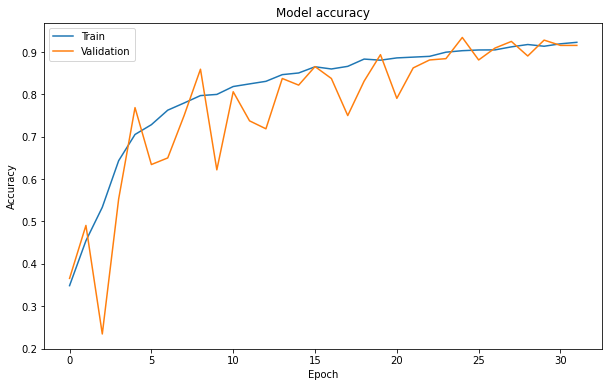

In [11]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

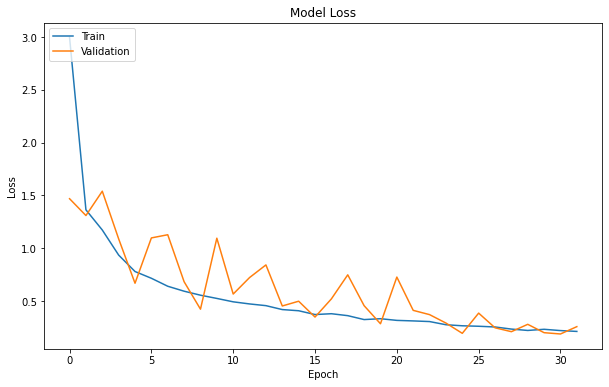

In [12]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()